# Computer Vision (CV2022): Assignment 2

### - Avirup Das (MDS202013)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 12)

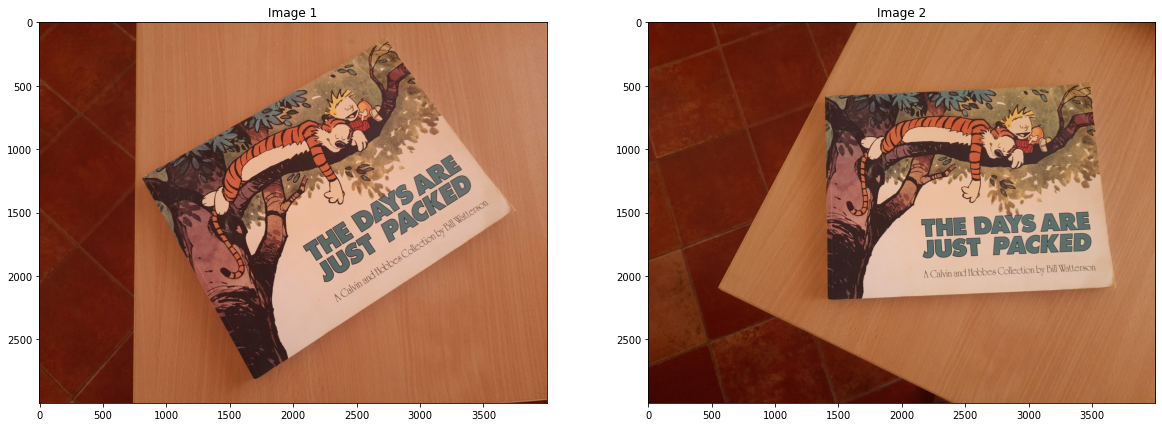

In [ ]:
# Reading images
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')
img3 = cv2.imread('image3.jpg')

# Displaying images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Image 2');

## Question 1

### Part a

In [ ]:
# top-left, bottom-left, bottom-right, top-right
pts1 = np.array([[814, 1236], [1696, 2819],  [3751, 1485], [2728, 127]])
pts2 = np.array([[1396, 594], [1420, 2185],  [3688, 2090], [3488, 481]])

### Part b

In [ ]:
def calc_A(pts1, pts2, n_points=4):
    A = []

    for i in range(0, n_points):
        x, y = pts1[i, 0], pts1[i, 1]
        x_1, y_1 = pts2[i, 0], pts2[i, 1]

        # here we are assuming w_i is 1
        A.append([0, 0, 0, -x, -y, -1, y_1*x, y_1*y, y_1])
        A.append([x, y, 1, 0, 0, 0, -x_1*x, -x_1*y, -x_1])

    assert (np.shape(A) == (2*n_points, 9))
    return np.asarray(A)

def homography(pts1, pts2):

  # Compute matrix A (of dimension 2n*9)
  A = calc_A(pts1, pts2)

  # Compute SVD of A
  U, S, V = np.linalg.svd(A)

  # Take h as last column of V
  h = V[-1, :]

  # Calculating homography
  H = h.reshape(3,3)

  return H

In [ ]:
# Calculating homography between image1 and image2 and storing in H
H = homography(pts1, pts2)
print('Homography between image1 and image2:', H, sep='\n')

Homography between image1 and image2:
[[-5.06152856e-04  2.54337484e-04 -8.59316329e-01]
 [-2.72849222e-04 -5.63538396e-04  5.11443331e-01]
 [ 1.54177337e-08 -2.07611999e-08 -6.72393220e-04]]


### Part c

In [ ]:
# Calculating homography using opencv and storing in h
h, _ = cv2.findHomography(pts1, pts2)
print('Homography between image1 and image2 (calculated using OpenCV):', h, sep='\n')

Homography between image1 and image2 (calculated using OpenCV):
[[ 7.52763176e-01 -3.78257063e-01  1.27799672e+03]
 [ 4.05788181e-01  8.38108385e-01 -7.60631303e+02]
 [-2.29296388e-05  3.08765752e-05  1.00000000e+00]]


In [ ]:
# Normalizing h to check whether it is a scalar multiple of H
h_new = h / np.linalg.norm(h)
print('Normalized h:', h_new, sep='\n')
print('\n\nThus our results are comparable to that from opencv')

Normalized h:
[[ 5.06152856e-04 -2.54337484e-04  8.59316329e-01]
 [ 2.72849222e-04  5.63538396e-04 -5.11443331e-01]
 [-1.54177337e-08  2.07611999e-08  6.72393220e-04]]


Thus our results are comparable to that from opencv


### Part d

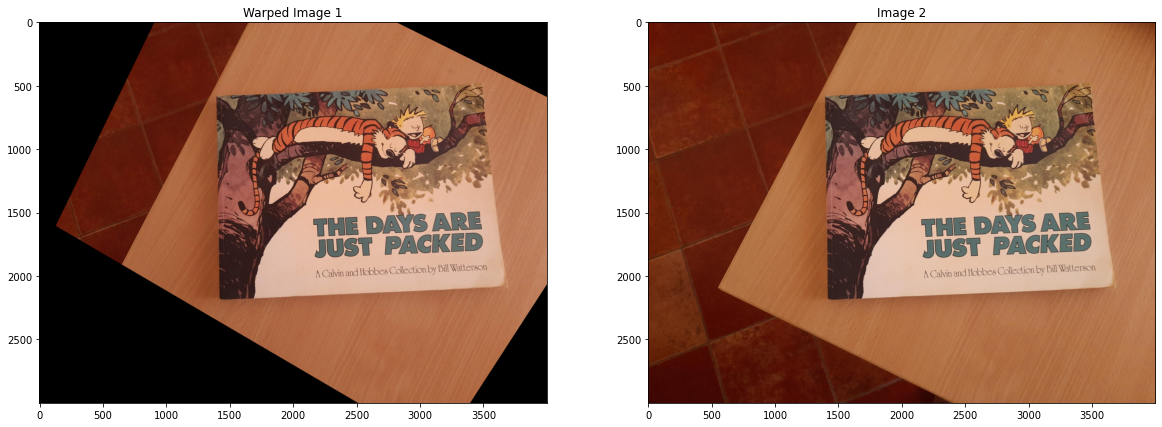

In [ ]:
# Warping image1 
out = cv2.warpPerspective(img1, H ,(img2.shape[1], img2.shape[0]))
fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax[0].set_title('Warped Image 1')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Image 2');

As we can see in the above two images, applying the homography on image1 has resulted in its 'rotation' or 'alignment' with image2, but a considerable amount of content (floor and table) of image1 is missing from the warped version, leaving black patches on the output. The reason being, the four points we had choses from image1, i.e. the source image, gets mapped on their corresponding points on image2 and along with that, all points from the image situated on the same plane undergo the same transformation. When we select a set of four (or more) points from the source image (here, image1), the plane on which these points reside in the real world gets aligned as the plane containing their four corresponding points in the destination image (here, image2). Thus, ALL points on that plane get aligned correctly as they are in the destinnation image. But the points that are NOT on that plane will NOT be aligned by the homography. These points get lost after the transformation leaving blank (black) pixels on the resulting picture.

## Question 2

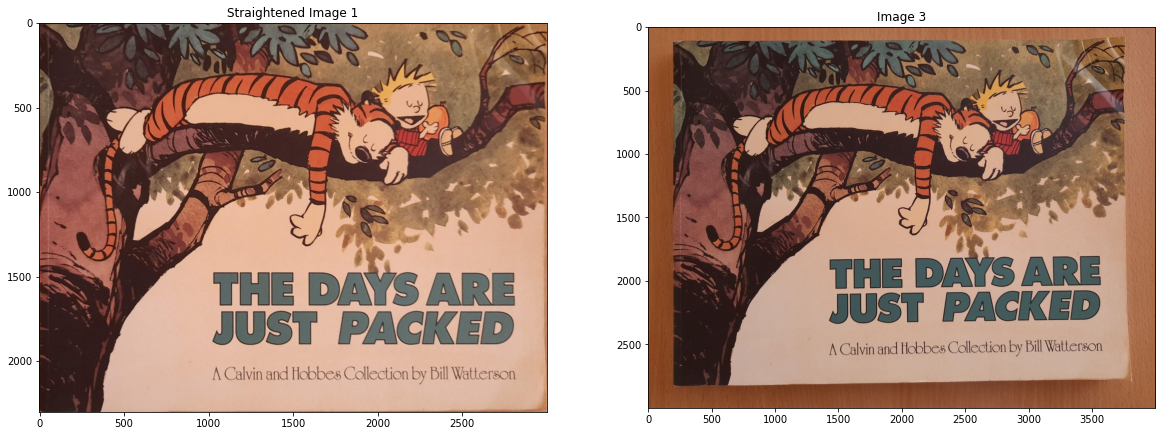

In [ ]:
# top-left, bottom-left, bottom-right, top-right

# Corner points of the book on source image
pts1 = np.array([[814, 1236], [1696, 2819],  [3751, 1485], [2728, 127]])

# Keeping aspect ratio as 30/23, the image size can be taken as 3000x2300
output_pts = np.array([[0,0], [0,2299], [2999,2299], [2999,0]])

# Calculating homography
H_new = homography(pts1, output_pts)

# Warping image
out = cv2.warpPerspective(img1, H_new ,(3000, 2300),flags=cv2.INTER_LINEAR)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax[0].set_title('Straightened Image 1')
ax[1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[1].set_title('Image 3');

## Question 3

### Application 1: Perspective Correction

Suppose we want to transform a source image or its part into a desired perspective. This can be done by computing the homography that maps the source points into the desired points. If we know the aspect ratio of the image, or the part of the image we want to correct the perspective of, this can be done quite easily.

For example, suppose we have the picture "image1" (used in Questions 1 and 2) and we want the image aligned in such a manner that the book in the image looks straight. This is actually what we did in Question 2. One of the best known application of this concept is in PDF corrections. PDF scanner apps have gained popularity in the past few years especially due to the Covid-19 pandemic. After clicking pictures of a few sheets of paper, the perspective of the images are corrected first and a bleached filter is applied to make it look more authentic.

Let us take an image of an A4-size answer script and change the perspective so that it is straightened out and is easily readable. Note that the aspect ratio of an A4-size sheet is $1:\sqrt{2}$

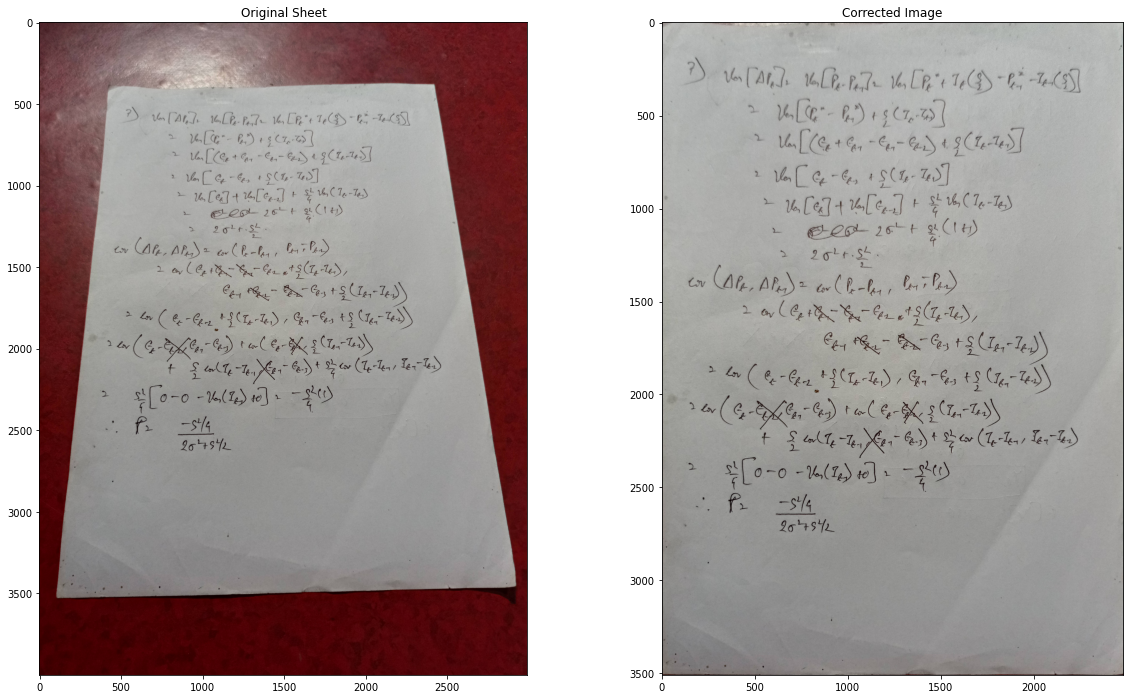

In [ ]:
# Reading image
img1 = cv2.imread('my_img1.jpg')

# Top left, bottom left, bottom right, top right corners of the paper
pts1 = np.array([[435, 399], [111, 3532], [2928, 3462], [2426, 390]])

# Keeping the aspect ratio as 1: sqrt(2), the image size can be taken as 3508 x 2480
out_pts =  np.array([[0,0], [0,3507], [2479,3507], [2479,0]])

# Calculating homography
H_new = homography(pts1, out_pts)

# Warping image
out = cv2.warpPerspective(img1, H_new ,(2480, 3508), flags=cv2.INTER_LINEAR)

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Sheet')
ax[1].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax[1].set_title('Corrected Image')
fig.savefig('Homography_correction.jpg')  

### Application 2: Fake highschool-yearbook

Let us try to create a fake yearbook using homology. We take a yearbook with the pictures of some of the stalwarts of Rock and Metal music. We will try to install our own picture into one of the slots of the yearbook using homography. 

In these kind of applications, the four corners of the yearbook slot serve as the destination points. The four corners of the picture (to be inserted), serve as the source points. A homography is calculated based on these four corresponding points and it is used to warp the photo of the individual into the yearbook.

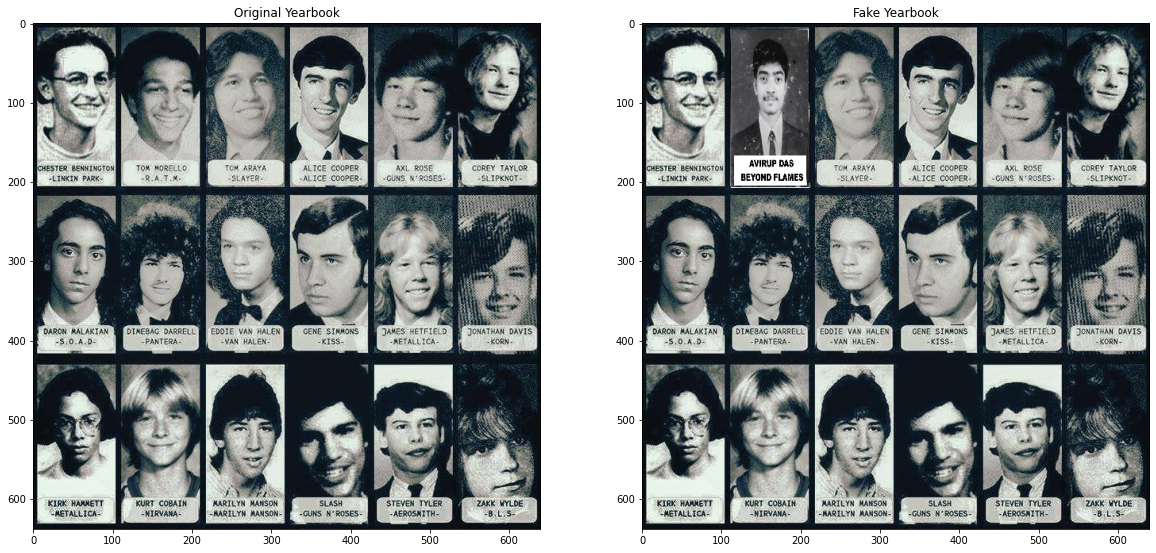

In [ ]:
# Reading images
yearbook = cv2.imread('my_img2.jpeg')
my_pic = cv2.imread('my_img3.jpg')

# Keeping a copy of original yearbook
yearbook_copy = yearbook.copy()

# Points on the yearbook picture where picture is to be installed
pts_yearbook = np.array([[111,8], [112, 207], [211, 207], [209, 7]])
# Corner points of the picture to be installed
pts_picture = np.array([[0,0], [0, my_pic.shape[0]-1],
                        [my_pic.shape[1]-1, my_pic.shape[0]-1], [my_pic.shape[1]-1, 0]])

# Calculating homography
H = homography(pts_picture, pts_yearbook)

# Warping picture
result = cv2.warpPerspective(my_pic, H, (yearbook.shape[1], yearbook.shape[0]), flags=cv2.INTER_LINEAR)

# Blackening the area where new picture is to be inserted
cv2.fillConvexPoly(yearbook, pts_yearbook, 0, 16)

# Generating final output
out = yearbook + result

fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(yearbook_copy, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Yearbook')
ax[1].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax[1].set_title('Fake Yearbook')
fig.savefig('Fake_yearbook.jpg')  

This application of homography is widely used in the advertisement industry. In many televised sports events, advertisements are virtually inserted in live video feed. For example, in soccer and baseball matches, the ads placed on small advertisement boards right outside the boundary of the field can be virtually changed. Instead of displaying the same ad to everybody, broadcasters can choose which ads to show based on the person’s demographics, location etc. 